# Imports

In [ ]:
# !pip install torch
# !pip install nibabel
# !pip PIL
# !pip install numpy
# !pip install torchio

In [ ]:
# #have to upgrade due to a version issue with TPU runtime
# !pip install --upgrade nibabel
# !pip install nibabel[arrayproxy]

In [ ]:
import nibabel as nb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sys
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import math
import pickle

# Load the stored npy data from drive

## Access the data

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/Publications and Researches/Multi-Disease, Multi-View & Multi-Center Right Ventricular Segmentation in Cardiac MRI/updated data"

/content/drive/MyDrive/Publications and Researches/Multi-Disease, Multi-View & Multi-Center Right Ventricular Segmentation in Cardiac MRI/updated data


## training

In [ ]:
images = np.load('MnM2/training/SA/images.npy')
masks = np.load('MnM2/training/SA/masks.npy')

## testing

In [ ]:
images_testing = np.load('MnM2/testing/SA/images.npy')
masks_testing = np.load('MnM2/testing/SA/masks.npy')

## validation

In [ ]:
images_validation = np.load('MnM2/validation/SA/images.npy')
masks_validation = np.load('MnM2/validation/SA/masks.npy')

# Transforms

In [ ]:
def replace_tensor_value_(tensor):
    return tensor

input_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

targets_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

# Hyperparams

In [ ]:
learning_rate = 0.0001
batch_size = 2
num_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The current processor is ...', device)

The current processor is ... cuda


In [ ]:
torch.cuda.empty_cache()

# Data Loaders

In [ ]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    self.data = data
    self.targets = targets

    self.transform = transform
    self.target_transform = target_transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
      x = self.data[index]
      x = self.transform(x)

    if self.target_transform:
      y = self.targets[index]
      y = self.target_transform(y)

    return x, y

  def __len__(self):
    return len(self.data)

train_dataset = MyDataset(images, masks, transform=input_transform, target_transform=targets_transform)

# del images
# del masks

test_dataset = MyDataset(images_testing, masks_testing, transform=input_transform, target_transform=targets_transform)

# del images_testing
# del masks_testing

val_dataset = MyDataset(images_validation, masks_validation, transform=input_transform, target_transform=targets_transform)

# del images_validation
# del masks_validation

train_loader = DataLoader(train_dataset, batch_size=batch_size)
del train_dataset

test_loader = DataLoader(test_dataset, batch_size=batch_size)
del test_dataset

val_loader = DataLoader(val_dataset, batch_size=batch_size)
del val_dataset

In [ ]:
inputs, classes = next(iter(train_loader))
inputs.shape, inputs.min(), inputs.max(), classes.shape, classes.min(), classes.max()

(torch.Size([2, 32, 240, 240]),
 tensor(0., dtype=torch.float64),
 tensor(3891.8333, dtype=torch.float64),
 torch.Size([2, 32, 240, 240]),
 tensor(0., dtype=torch.float64),
 tensor(3., dtype=torch.float64))

# Loss functions

## Dice Score and Loss

In [ ]:
import torch
from torch import Tensor

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    # print("input size", input.size())
    # print("target size", target.size())
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)


## Hausdorff distance

In [ ]:
def hausdorff_distance(tensor1, tensor2):
    # Reshape tensors to [batch_size, x] where x is flattened
    tensor1_flat = tensor1.reshape(2, -1)
    tensor2_flat = tensor2.reshape(2, -1)

    # Calculate pairwise Euclidean distance between all points
    distances = torch.cdist(tensor1_flat, tensor2_flat)

    # Find shortest distance from tensor1 to tensor2
    shortest_distance_1to2, _ = torch.min(distances, dim=1)

    # Find shortest distance from tensor2 to tensor1
    shortest_distance_2to1, _ = torch.min(distances, dim=0)

    # Hausdorff Distance is the maximum of the shortest distances
    hausdorff_distance = torch.max(shortest_distance_1to2.max(), shortest_distance_2to1.max())

    return hausdorff_distance

# def hd_loss(mask_pred, mask_true):
#     hd_distance = 0.0
#     hd_per_img = 0.0
#     for x,y in zip(mask_pred,mask_true):
#       # HD for a single voxel
#       dist = hausdorff_distance(x.cpu(), y.cpu())
#       hd_per_img += dist
#     # compute the averaged_hausdorff_distance, ignoring background
#     hd_distance += hd_per_img / batch_size
#     return hd_distance

def hd_loss(mask_pred, mask_true):
    num_classes = mask_pred.size(1)  # Number of classes
    batch_size = mask_pred.size(0)   # Batch size

    hd_loss_per_class = []

    for class_idx in range(num_classes):
        hd_per_class = 0.0
        for batch_idx in range(batch_size):
            # Calculate HD for a single class in a single image
            dist = hausdorff_distance(mask_pred[batch_idx, class_idx].cpu(), mask_true[batch_idx, class_idx].cpu())
            hd_per_class += dist

        # Average HD for this class across the batch
        hd_loss_per_class.append(hd_per_class / batch_size)

    # Compute the average HD loss across all classes
    loss = torch.mean(torch.stack(hd_loss_per_class))

    return loss

# UNet Model

## fixed

In [ ]:
import torch.nn as nn

import torch
import torch.nn as nn

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(ResidualBlock3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.PReLU(),
            nn.Dropout3d(dropout_rate),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels)
        )
        self.relu = nn.PReLU()

        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm3d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x
        out = self.conv(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

class PositionalEncoding3D(nn.Module):
    def __init__(self, channels):
        super(PositionalEncoding3D, self).__init__()
        self.channels = channels
        self.positional_encoding = None  # Initialized to None initially

    def forward(self, x):
        b, c, d, h, w = x.shape

        # If positional encoding is not initialized or if input size has changed, update positional encoding
        if self.positional_encoding is None or self.positional_encoding.shape[2:] != (d, h, w):
            self.positional_encoding = torch.zeros(1, c, d, h, w, device=x.device)
            nn.init.uniform_(self.positional_encoding, -0.1, 0.1)

        return x + self.positional_encoding

class AttentionBlock3D(nn.Module):
    def __init__(self, in_channels, heads=512):
        super(AttentionBlock3D, self).__init__()
        self.positional_encoding = PositionalEncoding3D(in_channels)
        self.attention = nn.MultiheadAttention(in_channels, num_heads=heads, batch_first=True)

    def forward(self, x):
        x = self.positional_encoding(x)  # Apply positional encoding
        b, c, d, h, w = x.shape  # Batch size, Channels, Depth, Height, Width
        x = x.flatten(2).permute(0, 2, 1)  # Flatten D, H, W dimensions and permute to (B, D*H*W, C)

        attn_output, _ = self.attention(x, x, x)  # Apply attention
        attn_output = attn_output.permute(0, 2, 1).view(b, c, d, h, w)  # Reshape back to original dimensions

        return attn_output


class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(UNet3D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout_rate = dropout_rate

        self.encoder1 = self.double_conv(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = self.double_conv(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.encoder3 = self.double_conv(64, 128)
        self.pool3 = nn.MaxPool3d(2)
        self.encoder4 = self.double_conv(128, 256)
        self.pool4 = nn.MaxPool3d(2)

        # self.middle = ResidualBlock3D(256, 512, dropout_rate)
        self.middle = nn.Sequential(
            self.double_conv(256, 512),
            AttentionBlock3D(512)
        )

        self.up1 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.decoder1 = self.double_conv(512, 256)
        self.up2 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.double_conv(256, 128)
        self.up3 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = self.double_conv(128, 64)
        self.up4 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.decoder4 = self.double_conv(64, 32)

        self.out_conv = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # print(x.shape)

        # print('-----------')

        # Encoder
        enc1 = self.encoder1(x)
        # print(enc1.shape)
        enc1_pool = self.pool1(enc1)
        # print(enc1_pool.shape)

        # print('-----------')

        enc2 = self.encoder2(enc1_pool)
        # print(enc2.shape)
        enc2_pool = self.pool2(enc2)
        # print(enc2_pool.shape)

        # print('-----------')

        enc3 = self.encoder3(enc2_pool)
        # print(enc3.shape)
        enc3_pool = self.pool3(enc3)
        # print(enc3_pool.shape)

        # print('-----------')

        enc4 = self.encoder4(enc3_pool)
        # print(enc4.shape)
        enc4_pool = self.pool4(enc4)
        # print(enc4_pool.shape)

        # print('-----------')

        # Middle
        middle = self.middle(enc4_pool)
        # print(middle.shape)

        # print('-----------')

        # Decoder
        dec1 = self.up1(middle)
        # print(dec1.shape)
        dec1 = torch.cat([enc4, dec1], dim=1)
        # print(dec1.shape)
        dec1 = self.decoder1(dec1)
        # print(dec1.shape)

        # print('-----------')

        dec2 = self.up2(dec1)
        # print(dec2.shape)
        dec2 = torch.cat([enc3, dec2], dim=1)
        dec2 = self.decoder2(dec2)
        # print(dec2.shape)

        # print('-----------')

        dec3 = self.up3(dec2)
        # print(dec3.shape)
        dec3 = torch.cat([enc2, dec3], dim=1)
        dec3 = self.decoder3(dec3)
        # print(dec3.shape)

        # print('-----------')

        dec4 = self.up4(dec3)
        # print(dec4.shape)
        dec4 = torch.cat([enc1, dec4], dim=1)
        dec4 = self.decoder4(dec4)
        # print(dec4.shape)

        # print('-----------')

        # Output
        output = self.out_conv(dec4)
        # print(output.shape)
        return output

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.PReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.PReLU())


## Resblocks + ViT

In [ ]:
import torch.nn as nn

import torch
import torch.nn as nn

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(ResidualBlock3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.PReLU(),
            nn.Dropout3d(dropout_rate),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels)
        )
        self.relu = nn.PReLU()

        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm3d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x
        out = self.conv(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

# class PositionalEncoding3D(nn.Module):
#     def __init__(self, channels):
#         super(PositionalEncoding3D, self).__init__()
#         self.channels = channels
#         # This parameter will dynamically adapt to the input size
#         self.register_buffer('positional_encoding', torch.empty(1, channels, 1, 1, 1))

#     def forward(self, x):
#         b, c, d, h, w = x.shape
#         if self.positional_encoding.shape[2:] != (d, h, w):
#             # Update positional encoding size based on input size
#             new_positional_encoding = torch.zeros(1, c, d, h, w, device=x.device)
#             nn.init.uniform_(new_positional_encoding, -0.1, 0.1)
#             self.positional_encoding = new_positional_encoding
#         return x + self.positional_encoding

import math
import torch
import torch.nn as nn

class PositionalEncoding3D(nn.Module):
    def __init__(self, channels):
        super(PositionalEncoding3D, self).__init__()
        self.channels = channels

    def forward(self, x):
        b, c, d, h, w = x.shape
        device = x.device

        if c % 2 != 0:
            raise ValueError("Channel count must be even for positional encoding.")

        # Calculate the positional encodings
        div_term = torch.exp(torch.arange(0., c, 2) * -(math.log(10000.0) / c)).to(device)

        # Depth
        pos_d = torch.arange(0., d, device=device).unsqueeze(1)
        pe_d = torch.zeros((d, c // 2), device=device)
        pe_d[:, 0::2] = torch.sin(pos_d * div_term)
        pe_d[:, 1::2] = torch.cos(pos_d * div_term)
        pe_d = pe_d.unsqueeze(1).unsqueeze(1)  # (d, 1, 1, c//2)

        # Height
        pos_h = torch.arange(0., h, device=device).unsqueeze(1)
        pe_h = torch.zeros((h, c // 2), device=device)
        pe_h[:, 0::2] = torch.sin(pos_h * div_term)
        pe_h[:, 1::2] = torch.cos(pos_h * div_term)
        pe_h = pe_h.unsqueeze(0).unsqueeze(2)  # (1, h, 1, c//2)

        # Width
        pos_w = torch.arange(0., w, device=device).unsqueeze(1)
        pe_w = torch.zeros((w, c // 2), device=device)
        pe_w[:, 0::2] = torch.sin(pos_w * div_term)
        pe_w[:, 1::2] = torch.cos(pos_w * div_term)
        pe_w = pe_w.unsqueeze(0).unsqueeze(1)  # (1, 1, w, c//2)

        # Combine the positional encodings
        pe = pe_d + pe_h + pe_w  # Broadcast sum
        pe = pe.permute(3, 0, 1, 2).unsqueeze(0)  # (1, c, d, h, w)
        pe = pe.expand(b, -1, -1, -1, -1)  # Match batch size

        return x + pee

class AttentionBlock3D(nn.Module):
    def __init__(self, in_channels, heads=8):
        super(AttentionBlock3D, self).__init__()
        self.positional_encoding = PositionalEncoding3D(in_channels)
        # Adjusting the head count to a more typical value for demonstration
        self.attention = nn.MultiheadAttention(in_channels, num_heads=heads, batch_first=True)
        self.in_channels = in_channels

    def forward(self, x):
        x = self.positional_encoding(x)  # Apply positional encoding

        b, c, d, h, w = x.shape  # Batch size, Channels, Depth, Height, Width

        # Flatten D, H, W dimensions and permute to (B, D*H*W, C)
        x = x.view(b, c, -1).permute(0, 2, 1)

        # Apply attention
        attn_output, _ = self.attention(x, x, x)

        # Reshape back to original dimensions
        attn_output = attn_output.permute(0, 2, 1).view(b, c, d, h, w)

        return attn_output

# class AttentionBlock3D(nn.Module):
#     def __init__(self, in_channels, heads=512):
#         super(AttentionBlock3D, self).__init__()
#         self.positional_encoding = PositionalEncoding3D(in_channels)
#         self.attention = nn.MultiheadAttention(in_channels, num_heads=heads, batch_first=True)

#     def forward(self, x):
#         x = self.positional_encoding(x)  # Apply positional encoding
#         b, c, d, h, w = x.shape  # Batch size, Channels, Depth, Height, Width
#         x = x.flatten(2).permute(0, 2, 1)  # Flatten D, H, W dimensions and permute to (B, D*H*W, C)

#         attn_output, _ = self.attention(x, x, x)  # Apply attention
#         attn_output = attn_output.permute(0, 2, 1).view(b, c, d, h, w)  # Reshape back to original dimensions

#         return attn_output



class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(UNet3D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout_rate = dropout_rate

        self.encoder1 = ResidualBlock3D(in_channels, 32, dropout_rate)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = ResidualBlock3D(32, 64, dropout_rate)
        self.pool2 = nn.MaxPool3d(2)
        self.encoder3 = ResidualBlock3D(64, 128, dropout_rate)
        self.pool3 = nn.MaxPool3d(2)
        self.encoder4 = ResidualBlock3D(128, 256, dropout_rate)
        self.pool4 = nn.MaxPool3d(2)

        # self.middle = ResidualBlock3D(256, 512, dropout_rate)
        self.middle = nn.Sequential(
            ResidualBlock3D(256, 512, dropout_rate),
            AttentionBlock3D(512)
        )

        self.up1 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.decoder1 = ResidualBlock3D(512, 256, dropout_rate)
        self.up2 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = ResidualBlock3D(256, 128, dropout_rate)
        self.up3 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = ResidualBlock3D(128, 64, dropout_rate)
        self.up4 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.decoder4 = ResidualBlock3D(64, 32, dropout_rate)

        self.out_conv = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # print(x.shape)

        # print('-----------')

        # Encoder
        enc1 = self.encoder1(x)
        # print(enc1.shape)
        enc1_pool = self.pool1(enc1)
        # print(enc1_pool.shape)

        # print('-----------')

        enc2 = self.encoder2(enc1_pool)
        # print(enc2.shape)
        enc2_pool = self.pool2(enc2)
        # print(enc2_pool.shape)

        # print('-----------')

        enc3 = self.encoder3(enc2_pool)
        # print(enc3.shape)
        enc3_pool = self.pool3(enc3)
        # print(enc3_pool.shape)

        # print('-----------')

        enc4 = self.encoder4(enc3_pool)
        # print(enc4.shape)
        enc4_pool = self.pool4(enc4)
        # print(enc4_pool.shape)

        # print('-----------')

        # Middle
        middle = self.middle(enc4_pool)
        # print(middle.shape)

        # print('-----------')

        # Decoder
        dec1 = self.up1(middle)
        # print(dec1.shape)
        dec1 = torch.cat([enc4, dec1], dim=1)
        # print(dec1.shape)
        dec1 = self.decoder1(dec1)
        # print(dec1.shape)

        # print('-----------')

        dec2 = self.up2(dec1)
        # print(dec2.shape)
        dec2 = torch.cat([enc3, dec2], dim=1)
        dec2 = self.decoder2(dec2)
        # print(dec2.shape)

        # print('-----------')

        dec3 = self.up3(dec2)
        # print(dec3.shape)
        dec3 = torch.cat([enc2, dec3], dim=1)
        dec3 = self.decoder3(dec3)
        # print(dec3.shape)

        # print('-----------')

        dec4 = self.up4(dec3)
        # print(dec4.shape)
        dec4 = torch.cat([enc1, dec4], dim=1)
        dec4 = self.decoder4(dec4)
        # print(dec4.shape)

        # print('-----------')

        # Output
        output = self.out_conv(dec4)
        # print(output.shape)
        return output

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.PReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.PReLU()
        )

# Training

In [ ]:
# Create the 3D UNet model
in_channels = 1
out_channels = 4
model = UNet3D(in_channels, out_channels).to(device)

In [ ]:
import torch
from torchsummary import summary

# Display the model summary
summary(model, input_size=(1, 240, 240, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 32, 240, 240, 32]             896
       BatchNorm3d-2     [-1, 32, 240, 240, 32]              64
             PReLU-3     [-1, 32, 240, 240, 32]               1
            Conv3d-4     [-1, 32, 240, 240, 32]          27,680
       BatchNorm3d-5     [-1, 32, 240, 240, 32]              64
             PReLU-6     [-1, 32, 240, 240, 32]               1
         MaxPool3d-7     [-1, 32, 120, 120, 16]               0
            Conv3d-8     [-1, 64, 120, 120, 16]          55,360
       BatchNorm3d-9     [-1, 64, 120, 120, 16]             128
            PReLU-10     [-1, 64, 120, 120, 16]               1
           Conv3d-11     [-1, 64, 120, 120, 16]         110,656
      BatchNorm3d-12     [-1, 64, 120, 120, 16]             128
            PReLU-13     [-1, 64, 120, 120, 16]               1
        MaxPool3d-14        [-1, 64, 60

In [ ]:
import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, 50, 0.1)
criterion = nn.CrossEntropyLoss()


from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)
criterion = nn.CrossEntropyLoss()
global_step = 0

## Test the model with one batch

In [ ]:
inputs, classes = next(iter(val_loader)) # without normalization
inputs.shape, inputs.min(), inputs.max(), classes.shape, classes.min(), classes.max()

(torch.Size([2, 32, 240, 240]),
 tensor(0., dtype=torch.float64),
 tensor(600.5000, dtype=torch.float64),
 torch.Size([2, 32, 240, 240]),
 tensor(0., dtype=torch.float64),
 tensor(3., dtype=torch.float64))

In [ ]:
in_batch = inputs.unsqueeze(1).to(dtype=torch.float).to(device)
in_batch.shape

torch.Size([1, 1, 32, 240, 240])

In [ ]:
#forward p
optimizer.zero_grad()
pred_mask = model(in_batch)

In [ ]:
print('shape of pred_mask: ', pred_mask.shape)
# Softmax - predictions
predicted_masks_ohe = F.softmax(pred_mask, dim=1).float()
classes_1 = classes.to(dtype=torch.long).to(device)
masks_one_hot = F.one_hot(classes_1, model.out_channels).float().permute(0, 4, 1, 2, 3)
print('shape of masks_one_hot: ',masks_one_hot.shape)
loss = criterion(pred_mask, masks_one_hot)
print("loss: ", loss.item())

shape of pred_mask:  torch.Size([1, 4, 32, 240, 240])
shape of masks_one_hot:  torch.Size([1, 4, 32, 240, 240])
loss:  1.2232102155685425


In [ ]:
#backward p
optimizer.zero_grad(set_to_none=True)
loss.backward()
optimizer.step()

## Training Loop

In [ ]:
training_data = {"loss":[], "epoch":[],"lr":[], "dice_loss":[], "hd_loss":[], "multiclass_dice_score": [] }
model_path = '../final_model/vanila_unet_512/sa-batch-size-2-RMSprop-CosineAnnealingLR-prelu-300-with-vit-512-heads'
num_epochs = 100
model.train()

UNet3D(
  (encoder1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
  )
  (pool2): MaxPool3d(ke

In [ ]:
min_loss = math.inf

# epoch loop
for epoch in range(num_epochs):

  total_loss = 0
  dice_loss_val = 0
  hd_loss_val = 0
  dice_score_val = 0
  # Dataloader
  for ix, (image, mask) in enumerate(train_loader):

    # zero the parameter gradients
    optimizer.zero_grad()

    # data compartmentalization
    image = image.unsqueeze(1).to(dtype=torch.float).to(device)
    mask = mask.to(dtype=torch.long).to(device)

    # forward prop
    predicted_masks = model(image)

    # One Hot Encode - mask
    masks_ohe = F.one_hot(mask, model.out_channels).float()
    masks_ohe = masks_ohe.permute(0, 4, 1, 2, 3)

    # Softmax - predictions
    predicted_masks_ohe = F.softmax(predicted_masks, dim=1).float()

    # loss
    mean_dice_loss = dice_loss(predicted_masks_ohe,  masks_ohe, multiclass=True)
    mean_hd_loss = hd_loss(predicted_masks_ohe,  masks_ohe)


    lambda_param = (mean_hd_loss/mean_dice_loss) if epoch == 0 else (epoch_hd_loss_val/epoch_dice_loss_val)
    loss = lambda_param * mean_dice_loss + mean_hd_loss

    with torch.no_grad():
      dice_score = multiclass_dice_coeff(predicted_masks_ohe,  masks_ohe, reduce_batch_first=False)
      total_loss += loss.item()
      dice_loss_val += mean_dice_loss.item()
      hd_loss_val += mean_hd_loss.item()
      dice_score_val += dice_score.item()

    # back prop + optim
    # optimizer.zero_grad(set_to_none=True)
    # loss.backward()
    # optimizer.step()

    grad_scaler.scale(loss).backward()
    grad_scaler.step(optimizer)
    grad_scaler.update()

  epoch_loss = total_loss / len(train_loader)
  epoch_dice_loss_val = dice_loss_val / len(train_loader)
  epoch_hd_loss_val = hd_loss_val / len(train_loader)
  epoch_dice_score = dice_score_val / len(train_loader)
  length = len(training_data['loss'])

  scheduler.step()

  training_data["loss"].append(epoch_loss) # append average accuracy for this epoch
  training_data["epoch"].append(epoch + 200)
  training_data["lr"].append(optimizer.param_groups[0]['lr'])
  training_data["dice_loss"].append(epoch_dice_loss_val)
  training_data["hd_loss"].append(epoch_hd_loss_val)
  training_data["multiclass_dice_score"].append(epoch_dice_score)

  print(f'Epoch {epoch + 201}/{num_epochs}, Loss: {epoch_loss:.4f}, Dice Loss: {epoch_dice_loss_val:.4f}, Epoch Dice Score: {epoch_dice_score:.4f}, HD Loss: {epoch_hd_loss_val:.4f}, lr: {optimizer.param_groups[0]["lr"]:.4f}')
  if epoch_loss < min_loss:
    torch.save(model.state_dict(), f'{model_path}.pt')
    with open(f'{model_path}.pkl', 'wb') as f:
        pickle.dump(training_data, f)

    min_loss = epoch_loss

OutOfMemoryError: CUDA out of memory. Tried to allocate 450.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 64.81 MiB is free. Process 60995 has 39.49 GiB memory in use. Of the allocated memory 38.75 GiB is allocated by PyTorch, and 219.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Save and Load model

In [ ]:
#persist full training data
with open(f'{model_path}.pkl', 'wb') as f:
        pickle.dump(training_data, f)
len(training_data['epoch'])

200

In [ ]:
import pickle

#model_path = '../final_model/vanila_unet_512/sa-batch-size-4-RMSprop-CosineAnnealingLR-prelu-200-with-resblocks-dropout-vit'

model_path = '../final_model/vanila_unet_512/sa-batch-size-2-RMSprop-CosineAnnealingLR-prelu-200-with-vit-512-heads-final'
# Save the model to a file
# torch.save(model.state_dict(), f'{model_path}.pt')
# with open(f'{model_path}.pkl', 'wb') as f:
#     pickle.dump(training_data, f)

# Later, you can load the model from the file
model = UNet3D(1,4).to(device)
model.load_state_dict(torch.load(f'{model_path}.pt'))
with open(f'{model_path}.pkl', 'rb') as filehandle:
    loaded_training_data  = pickle.load(filehandle)

In [ ]:
for i in range(len(loaded_training_data['epoch'])):
  print(f"({loaded_training_data['epoch'][i]}, {loaded_training_data['hd_loss'][i]})")

(0, 133.09652216434478)
(1, 85.43456523418426)
(2, 79.26420238018036)
(3, 75.68928112983704)
(4, 72.51664574146271)
(5, 71.68386471271515)
(6, 70.05211546421052)
(7, 67.62487342357636)
(8, 65.67481451034546)
(9, 65.18441417217255)
(10, 64.49067072868347)
(11, 63.34656100273132)
(12, 62.49880862236023)
(13, 63.175710225105284)
(14, 63.40833878517151)
(15, 63.41621570587158)
(16, 63.5468145608902)
(17, 62.98452482223511)
(18, 63.13879842758179)
(19, 62.06951525211334)
(20, 61.25643980503082)
(21, 61.089410710334775)
(22, 59.84541662931442)
(23, 57.85255753993988)
(24, 57.896926033496854)
(25, 56.23837020397186)
(26, 54.85620350837708)
(27, 54.11877925395966)
(28, 53.70088355541229)
(29, 53.55774629116058)
(30, 53.29000558853149)
(31, 52.673410856723784)
(32, 51.80400140285492)
(33, 51.83033497333527)
(34, 51.46779143810272)
(35, 51.48444800376892)
(36, 52.65011341571808)
(37, 53.919025933742525)
(38, 53.02797003984451)
(39, 52.72971531152725)
(40, 52.339522135257724)
(41, 52.235786032676

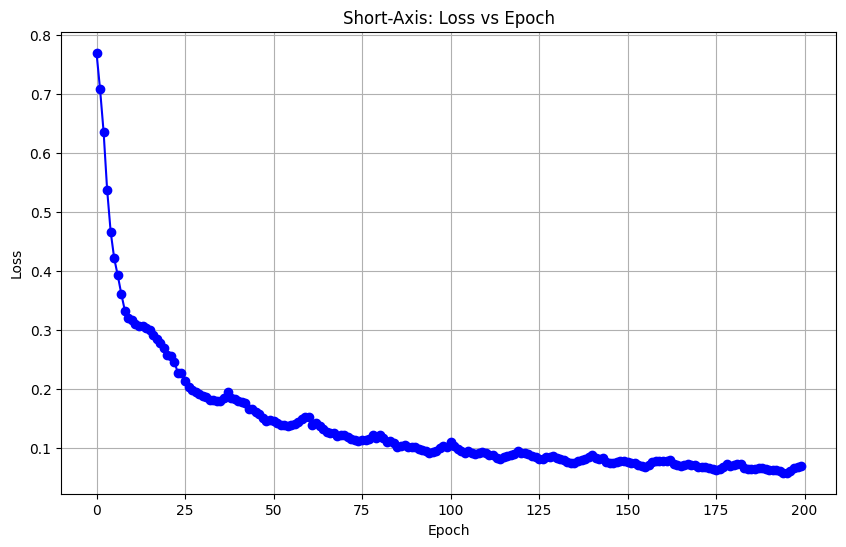

In [ ]:
import matplotlib.pyplot as plt

epoch = loaded_training_data['epoch']
loss = loaded_training_data['loss']
dice_loss = loaded_training_data['dice_loss']
hd_loss = loaded_training_data['hd_loss']

# plot epoch vs loss
plt.figure(figsize=(10, 6))
plt.plot(epoch, dice_loss, marker='o', linestyle='-', color='b')
plt.title('Short-Axis: Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


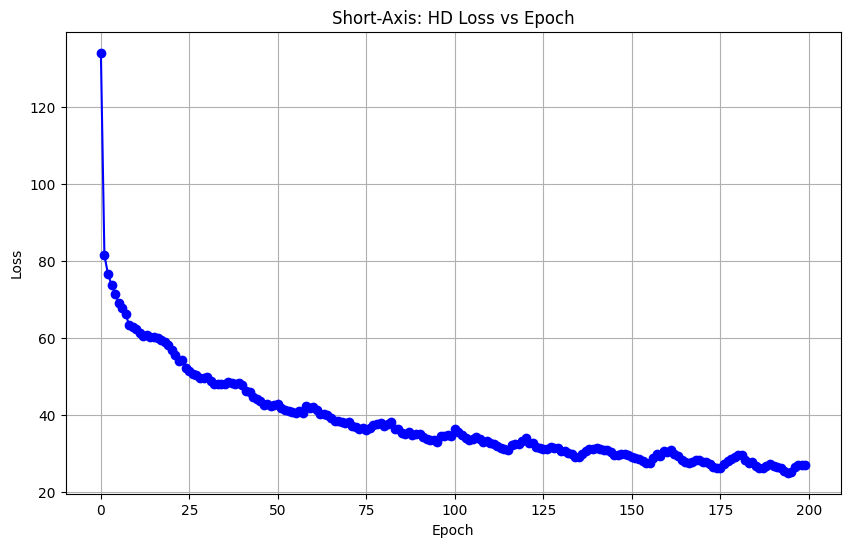

In [ ]:
# plot epoch vs hd loss
plt.figure(figsize=(10, 6))
plt.plot(epoch, hd_loss, marker='o', linestyle='-', color='b')
plt.title('Short-Axis: HD Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


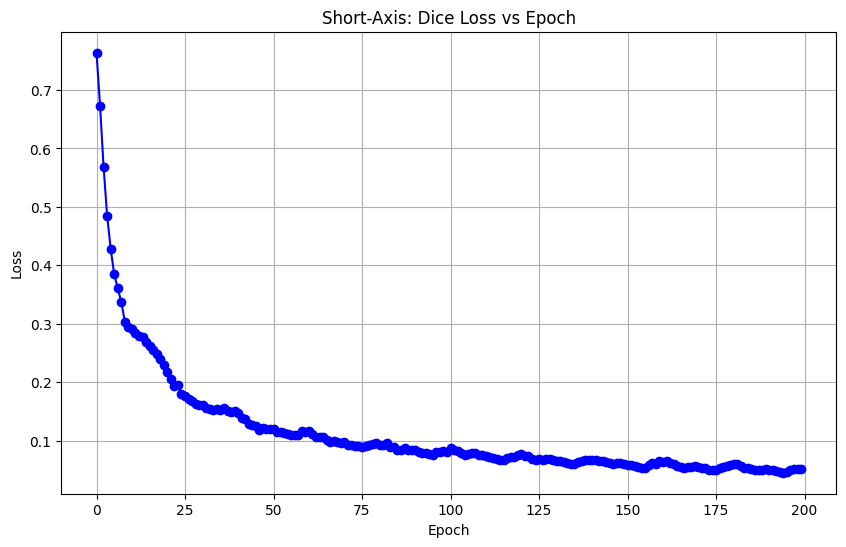

In [ ]:
# plot epoch vs dice loss
plt.figure(figsize=(10, 6))
plt.plot(epoch, dice_loss, marker='o', linestyle='-', color='b')
plt.title('Short-Axis: Dice Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluate

In [ ]:
# Eval mode
model.eval()

UNet3D(
  (encoder1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
  )
  (pool2): MaxPool3d(ke

## Dice Score

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def evaluate(net, dataloader, device):
    num_val_batches = len(dataloader)
    dice_scores = [0] * net.out_channels  # Initialize a list to store Dice scores for each class

    # iterate over the validation set
    for ix, (images, true_masks) in enumerate(dataloader):
        # data compartmentalization
        image = images.unsqueeze(1).float().to(device)
        mask_true = true_masks.to(dtype=torch.long).to(device)

        # One Hot Encode
        mask_true = F.one_hot(mask_true, net.out_channels).float().permute(0, 4, 1, 2, 3)

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)

            # Convert predictions to labels
            mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.out_channels).float().permute(0, 4, 1, 2, 3)

            # compute the Dice score for each class (channel)
            for channel in range(net.out_channels):
                dice_scores[channel] += dice_coeff(mask_pred[:, channel, ...], mask_true[:, channel, ...], reduce_batch_first=False)

    # Calculate the average Dice score for each class
    scores = [f"class {i} : {dice_score.item() / num_val_batches}" for i, dice_score in enumerate(dice_scores)]
    avg_dice_score = torch.mean(torch.stack(dice_scores)) / num_val_batches
    scores.append(f"average: {avg_dice_score}")

    return scores

In [ ]:
evaluate(model, train_loader, device) # Train Dice Score

['class 0 : 0.9994139671325684',
 'class 1 : 0.9598132133483886',
 'class 2 : 0.9344660758972168',
 'class 3 : 0.9528299331665039',
 'average: 0.9616308212280273']

In [ ]:
evaluate(model, val_loader, device) # Validation Dice Score

['class 0 : 0.998685646057129',
 'class 1 : 0.9262928009033203',
 'class 2 : 0.8934456825256347',
 'class 3 : 0.9087743759155273',
 'average: 0.9317997097969055']

In [ ]:
evaluate(model, test_loader, device) # Test Dice Score

['class 0 : 0.9972763061523438',
 'class 1 : 0.9078340530395508',
 'class 2 : 0.8677481651306153',
 'class 3 : 0.8656583786010742',
 'average: 0.9096292853355408']

## Hausdorf

In [ ]:
import torch
import torch.nn.functional as F

def evaluation_hd(net, dataloader, device):
    num_val_batches = len(dataloader)
    num_classes = net.out_channels  # Number of classes
    hd_loss_per_class = [0.0] * num_classes  # Initialize HD loss for each class

    # iterate over the validation set
    for ix, (images, true_masks) in enumerate(dataloader):

        # data compartmentalization
        image = images.unsqueeze(1).float().to(device)
        mask_true = true_masks.to(dtype=torch.long).to(device)

        # One Hot Encode
        mask_true = F.one_hot(mask_true, net.out_channels).float().permute(0, 4, 1, 2, 3)

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)

            # Convert predictions to labels
            mask_pred = F.one_hot(mask_pred.argmax(dim=1), num_classes).float().permute(0, 4, 1, 2, 3)
            batch_size = mask_pred.size(0)

            for class_idx in range(num_classes):
                hd_per_class = 0.0
                for batch_idx in range(batch_size):
                    # Calculate HD for a single class in a single image
                    dist = hausdorff_distance(mask_pred[batch_idx, class_idx], mask_true[batch_idx, class_idx])
                    hd_per_class += dist

                # Accumulate HD loss for this class
                hd_loss_per_class[class_idx] += hd_per_class/batch_size

    scores = [f"class {i} : {hd_score / num_val_batches}" for i, hd_score in enumerate(hd_loss_per_class)]
    avg_hd_score = torch.mean(torch.stack(hd_loss_per_class)) / num_val_batches
    scores.append(f"average: {avg_hd_score}")

    return scores



In [ ]:
evaluation_hd(model, train_loader, device) # Training Hausdorff Dist

['class 0 : 43.21687316894531',
 'class 1 : 28.041828155517578',
 'class 2 : 40.32204818725586',
 'class 3 : 31.176565170288086',
 'average: 35.689327239990234']

In [ ]:
evaluation_hd(model, val_loader, device) # Validation Hausdorff Dist

['class 0 : 65.17825317382812',
 'class 1 : 37.55491256713867',
 'class 2 : 49.71796798706055',
 'class 3 : 47.98231506347656',
 'average: 50.10836410522461']

In [ ]:
evaluation_hd(model, test_loader, device) # Test Hausdorff Dist

['class 0 : 88.83905029296875',
 'class 1 : 50.958736419677734',
 'class 2 : 61.8352165222168',
 'class 3 : 64.11592864990234',
 'average: 66.4372329711914']

# Display Predicted Image

In [ ]:
def plot_pred_images(image, gt_image, pred_image, ix):
    fig = plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Index: '+str(ix))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(gt_image)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    # plt.imshow(np.fliplr(np.rot90(pred_image, k=-1)))
    plt.imshow(pred_image)
    plt.title('Prediction')
    plt.axis('off')
    plt.show()


In [ ]:
def predict_img(net, full_img, groud_truth, device):
    net.eval()

    with torch.no_grad():

        output = net(full_img.unsqueeze(1).to(device))

        final_mask_batch = []

        output = output.permute(0,2,1,3,4)

        for img3d in output:
          im2 = []
          for img2d in img3d:
            final_mask = np.argmax(img2d.cpu().detach().numpy(), axis=0)
            im2.append(final_mask)
          final_mask_batch.append(im2)

        final_mask_batch = np.array(final_mask_batch)

    for ix, (a,b,c) in enumerate(zip(full_img, groud_truth, final_mask_batch)):
      print("============================= 3D image no: " + str(ix+1) )
      for ix, (img, lbl, pred) in enumerate(zip(a,b,c)):
        # Filter out the black-empty images
        if not torch.all(img == 0):
          plot_pred_images(img, lbl, pred, ix)

============================= 3D image no: 1


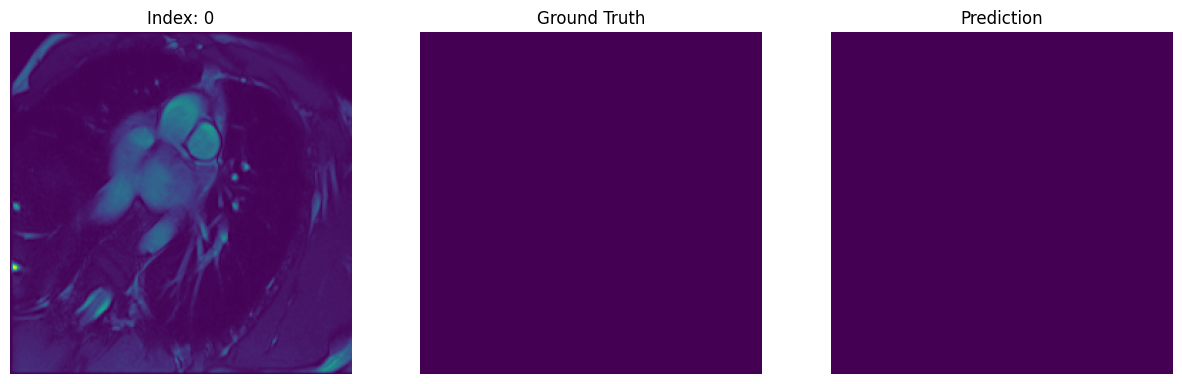

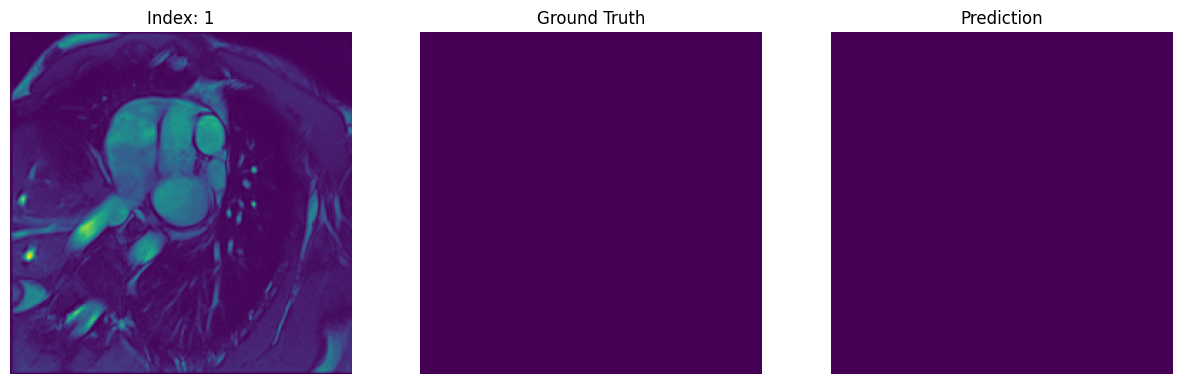

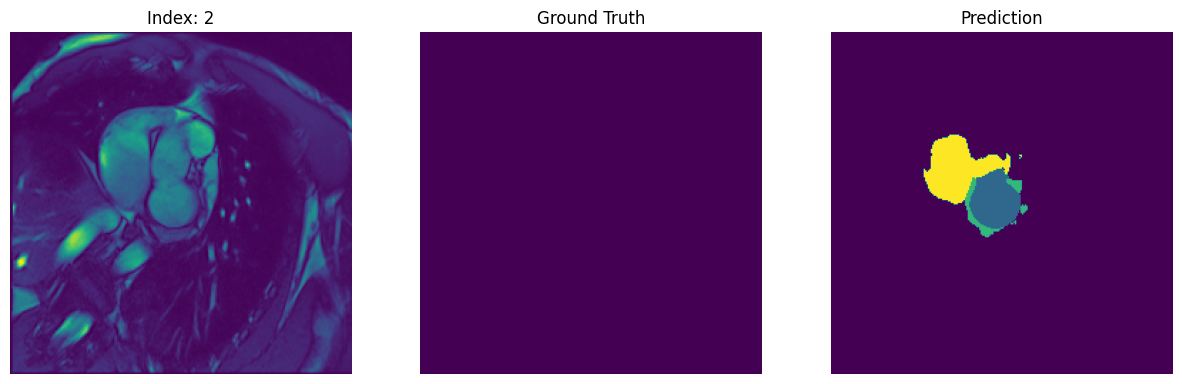

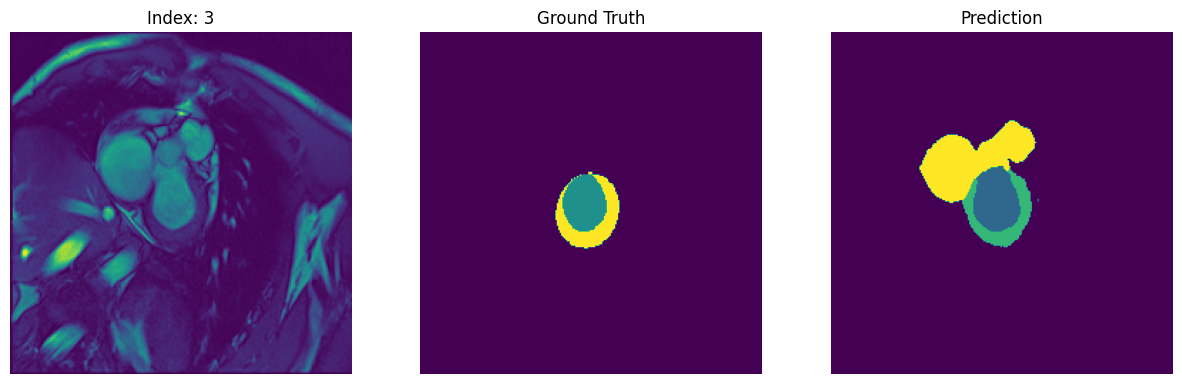

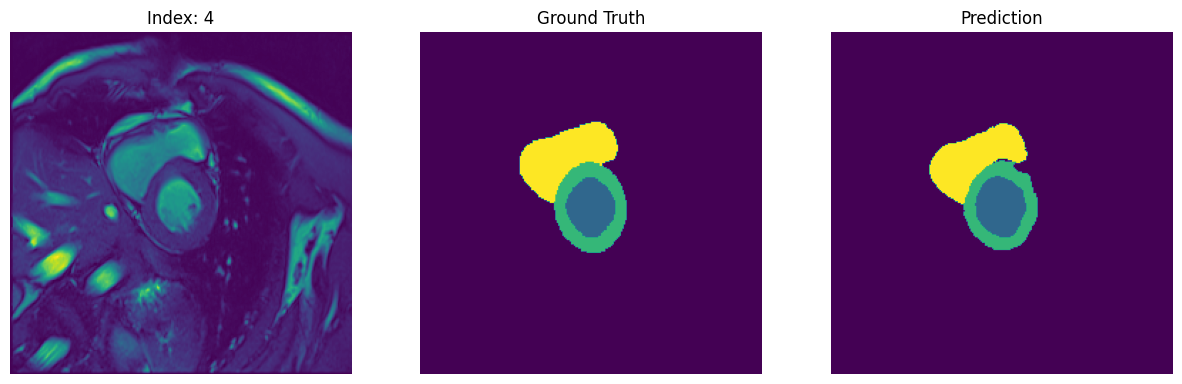

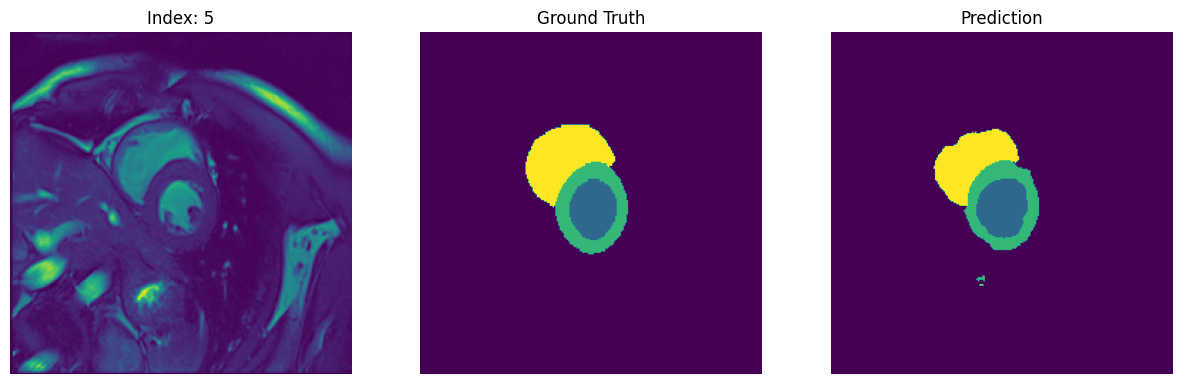

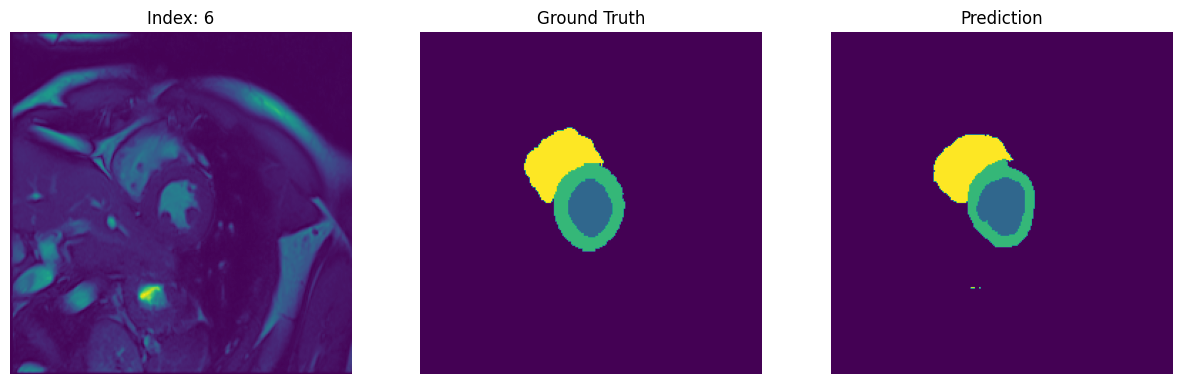

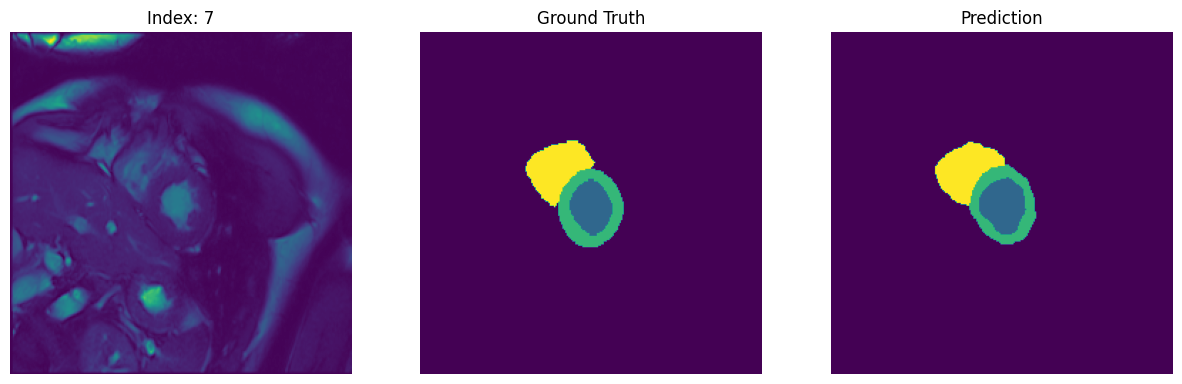

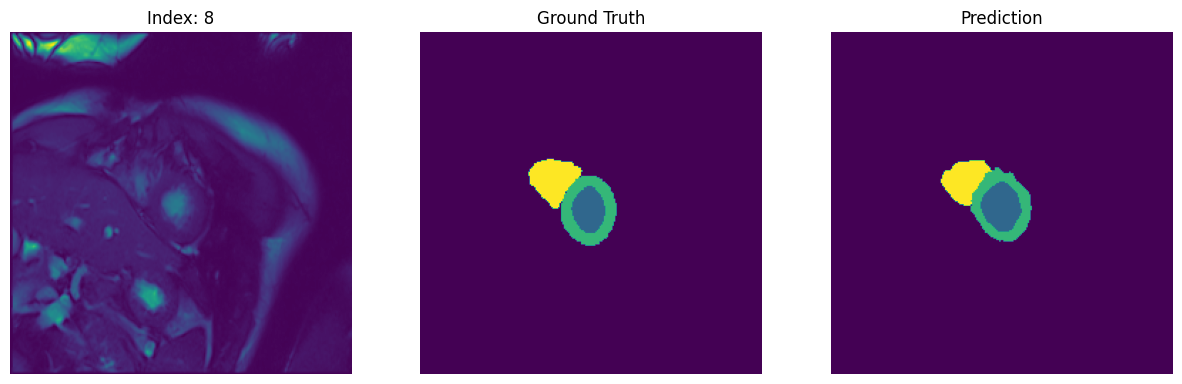

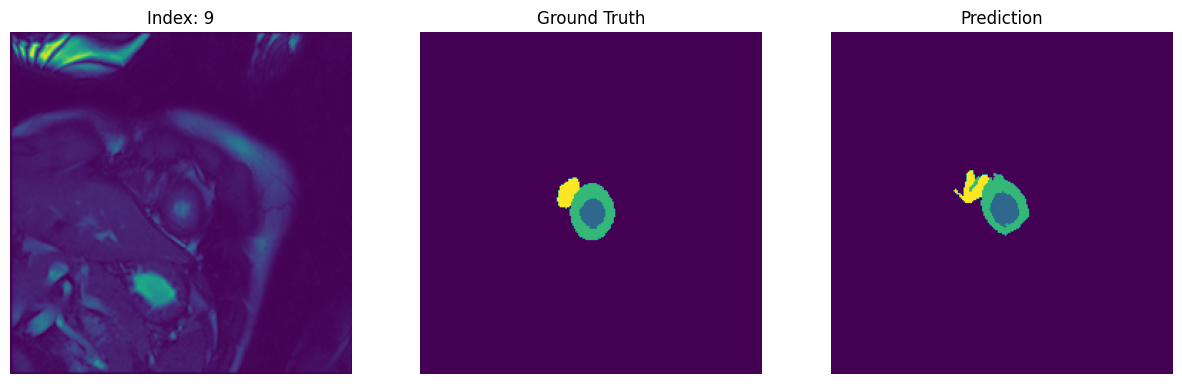

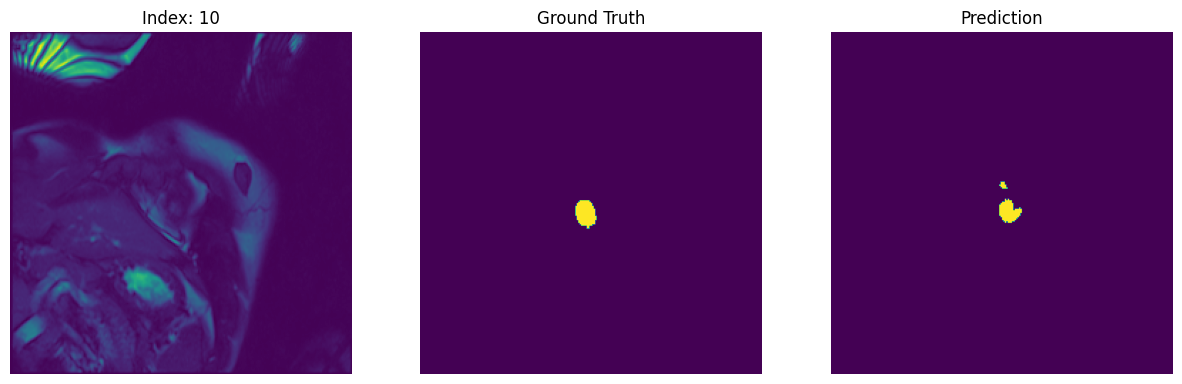

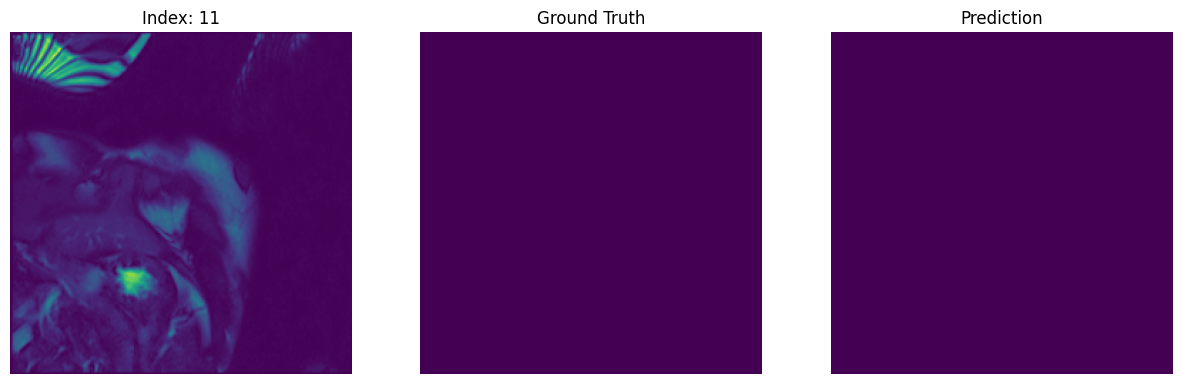

============================= 3D image no: 2


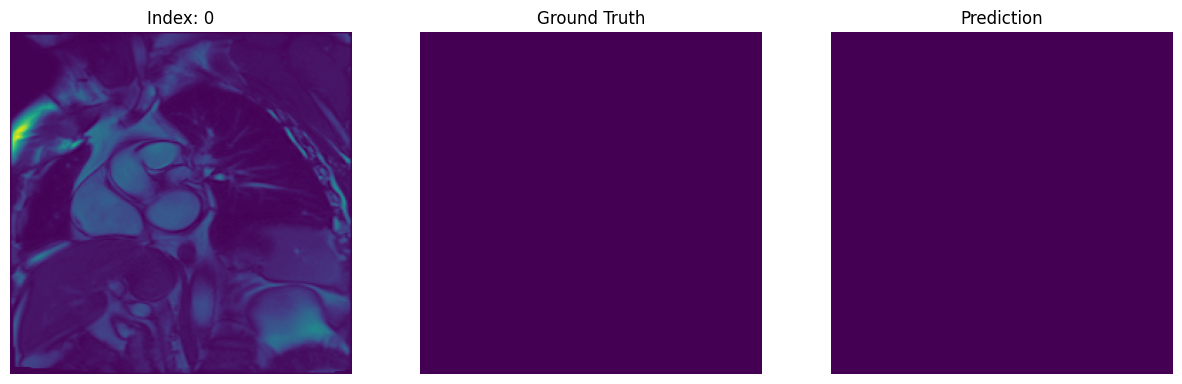

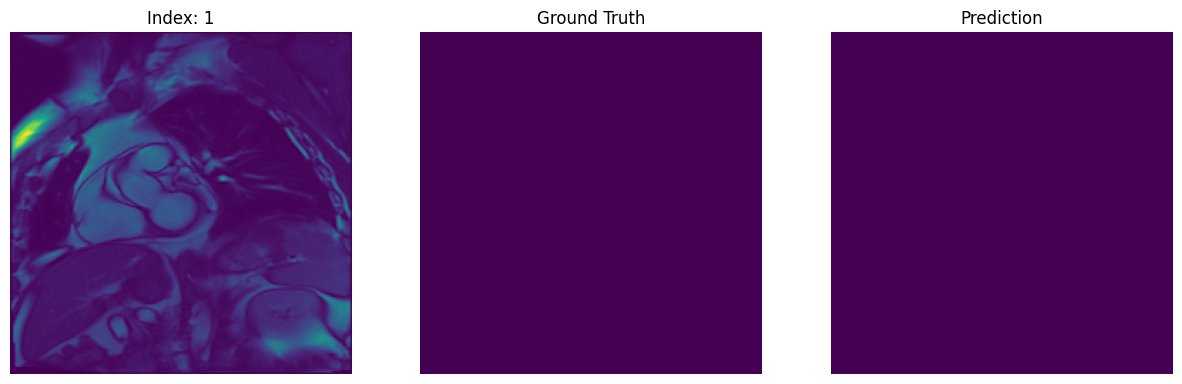

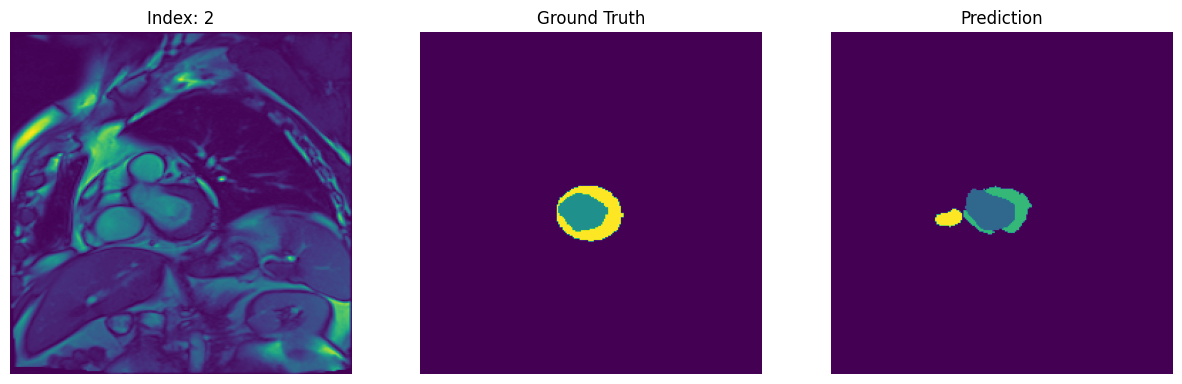

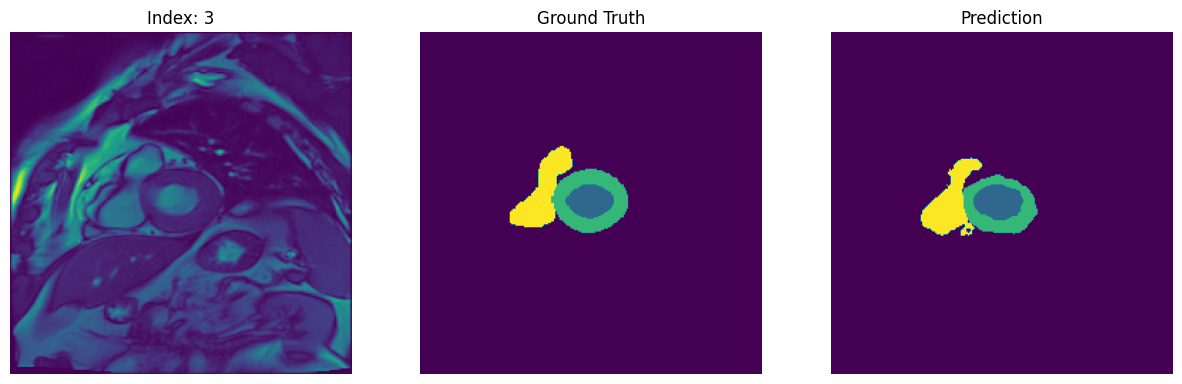

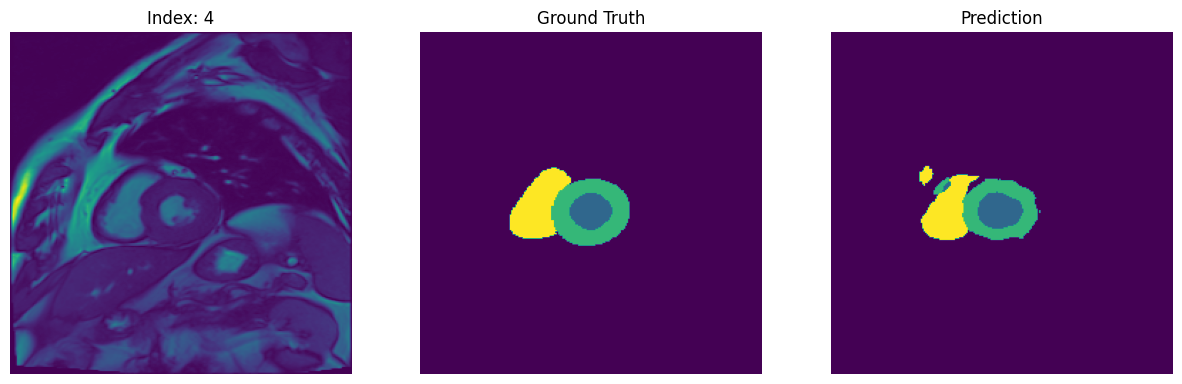

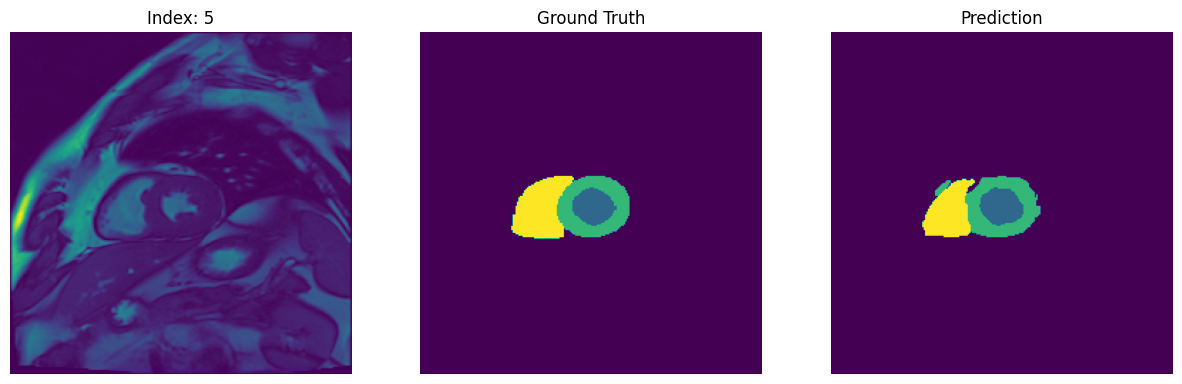

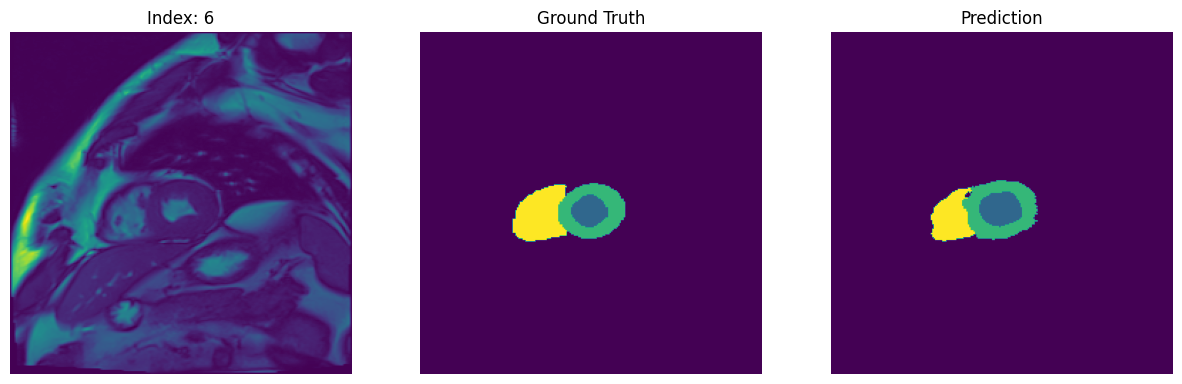

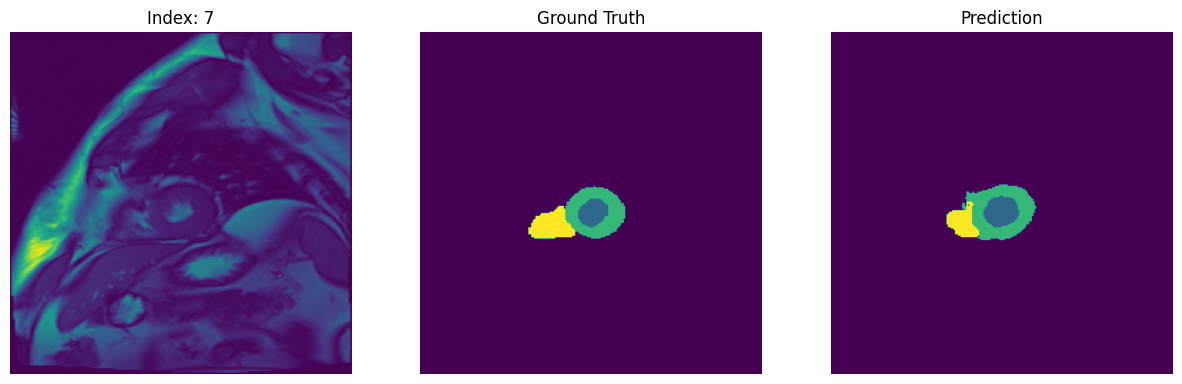

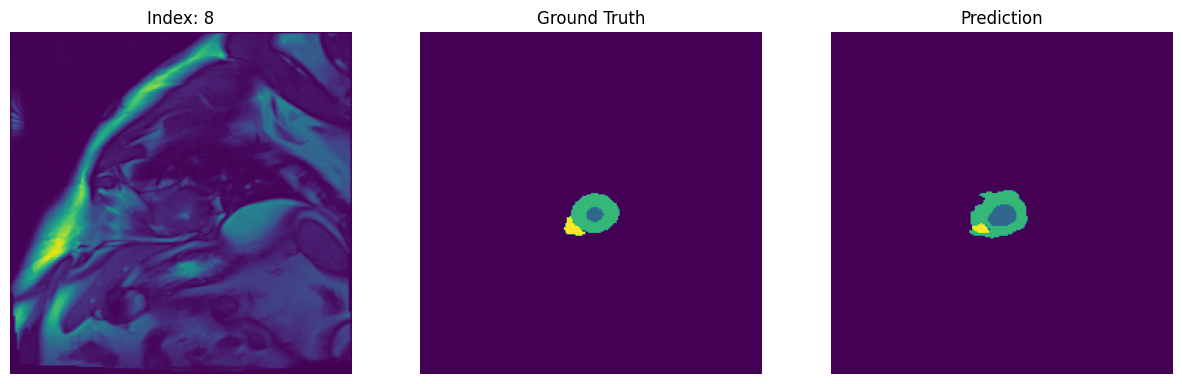

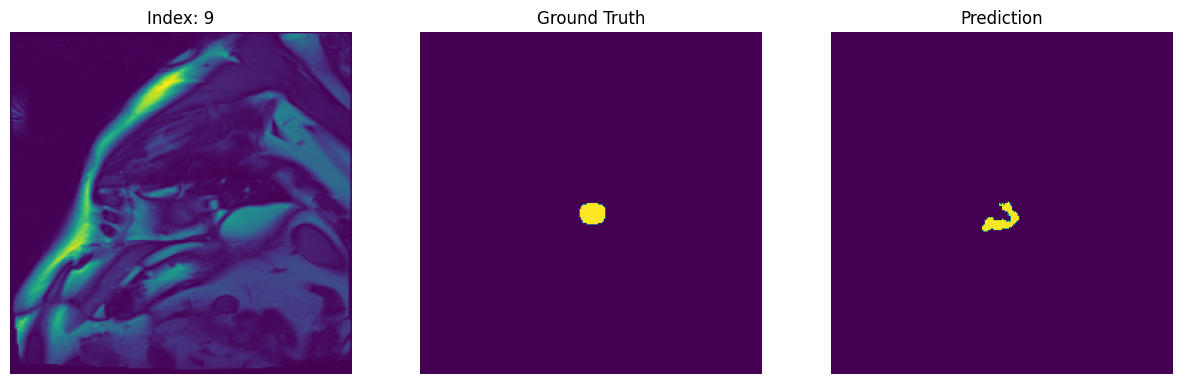

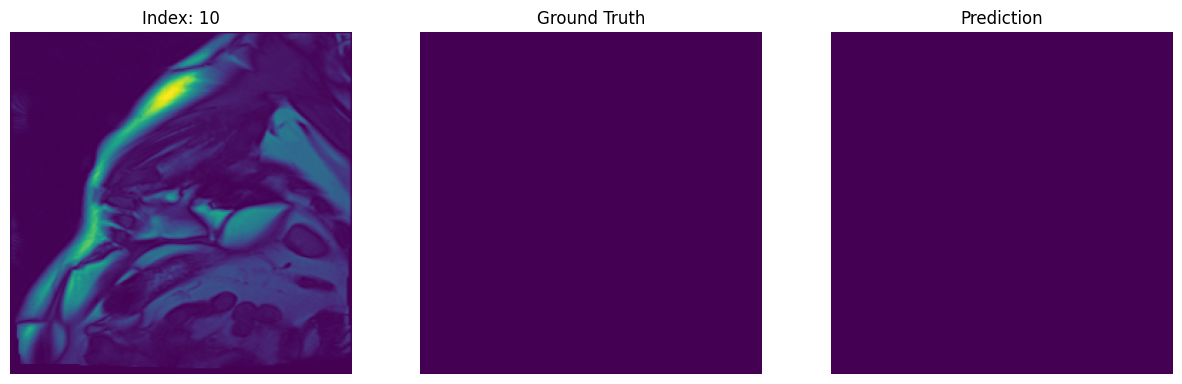

In [ ]:
inputs, classes = next(iter(test_loader))
predict_img(model,inputs.float(), classes, device)

============================= 3D image no: 1


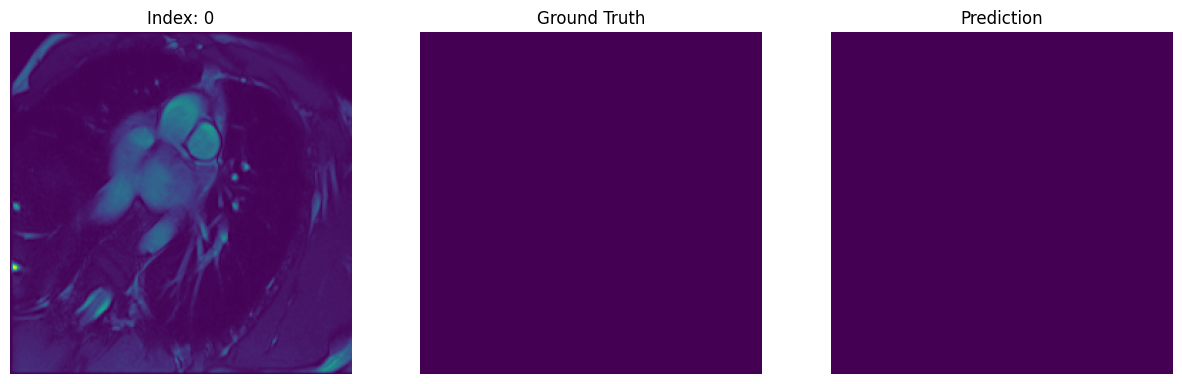

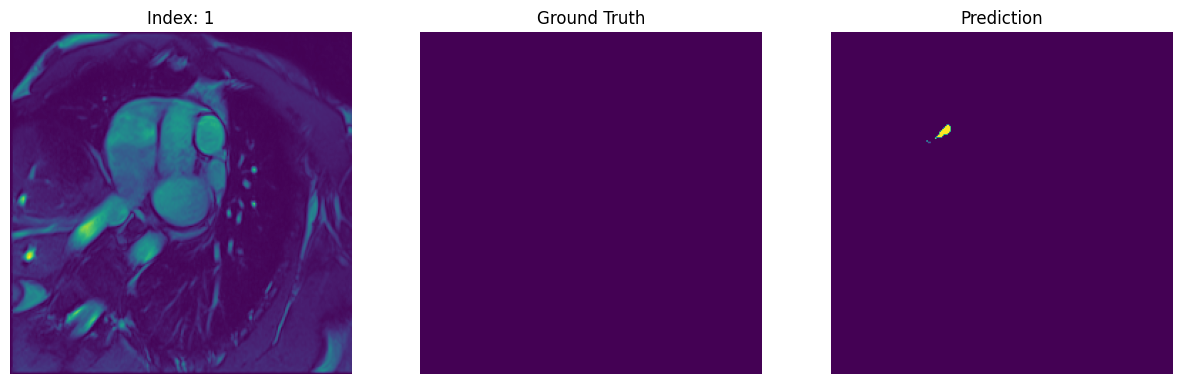

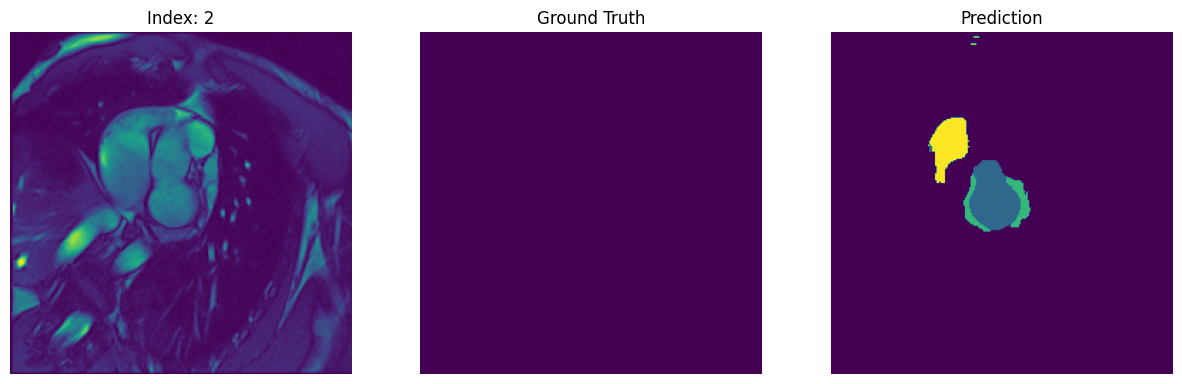

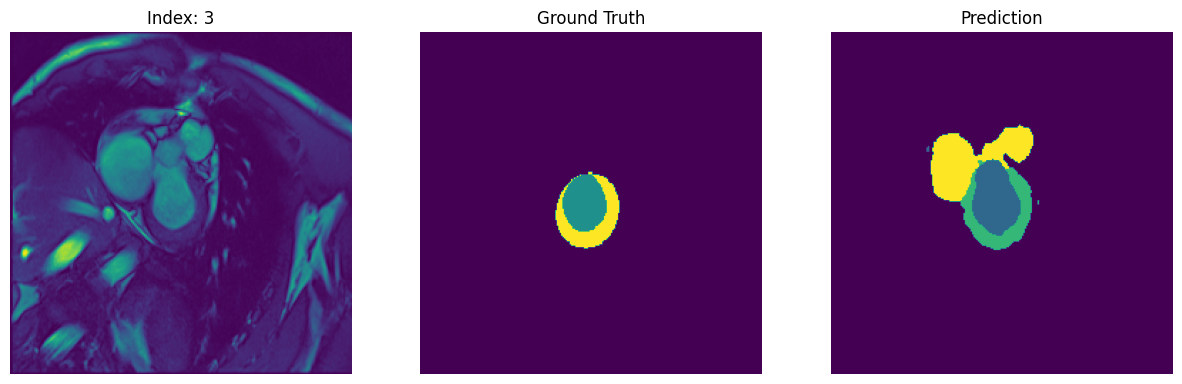

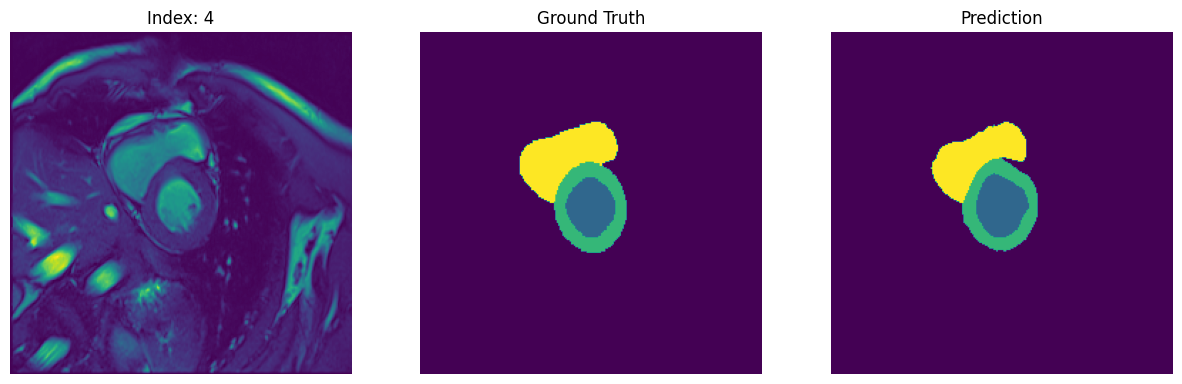

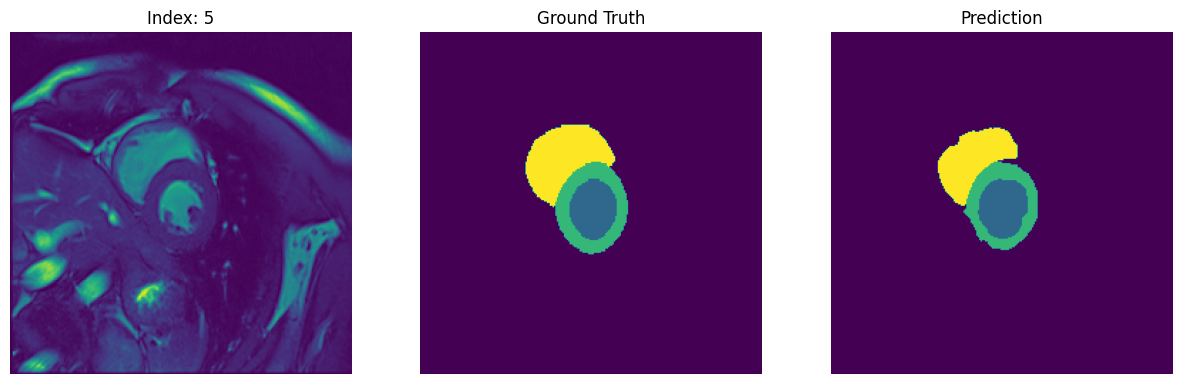

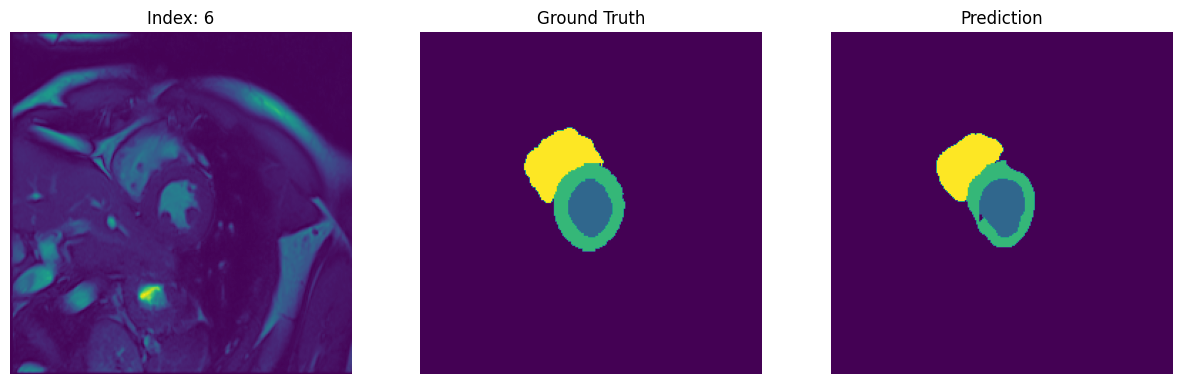

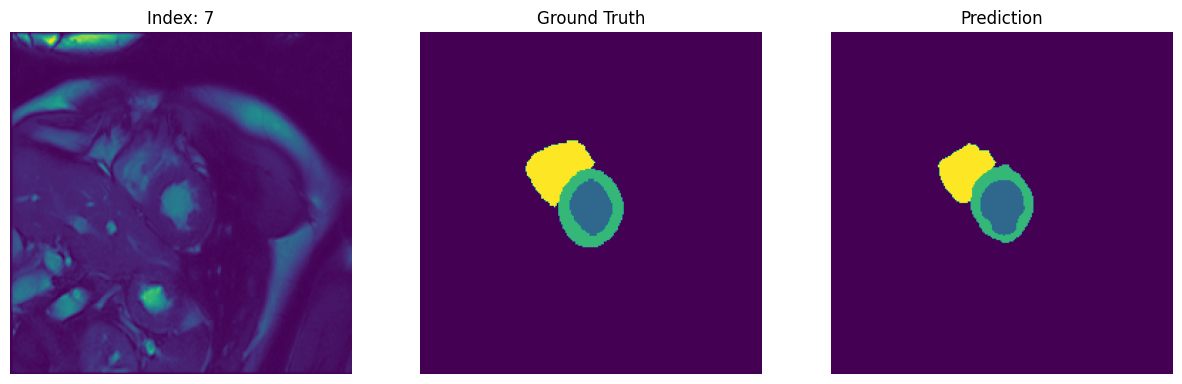

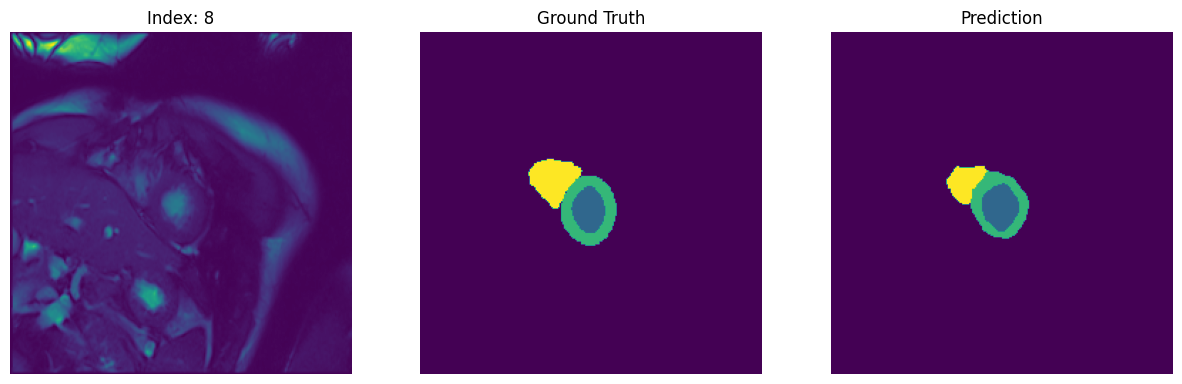

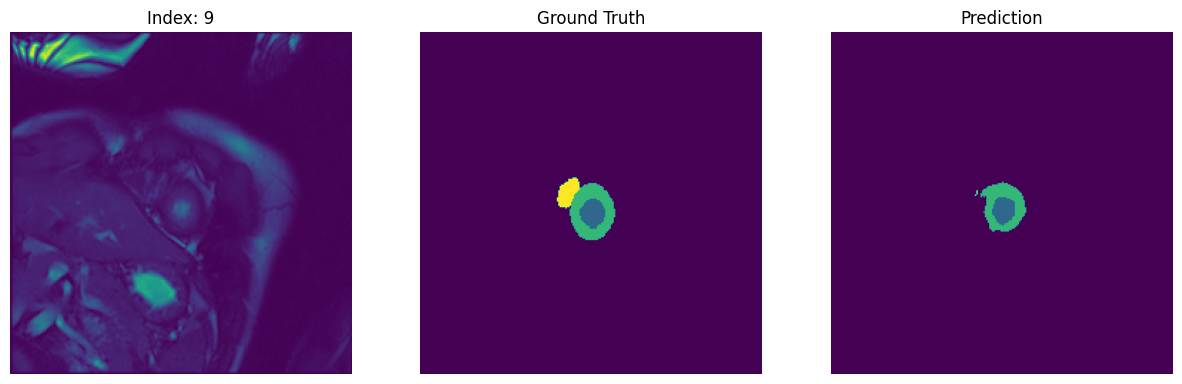

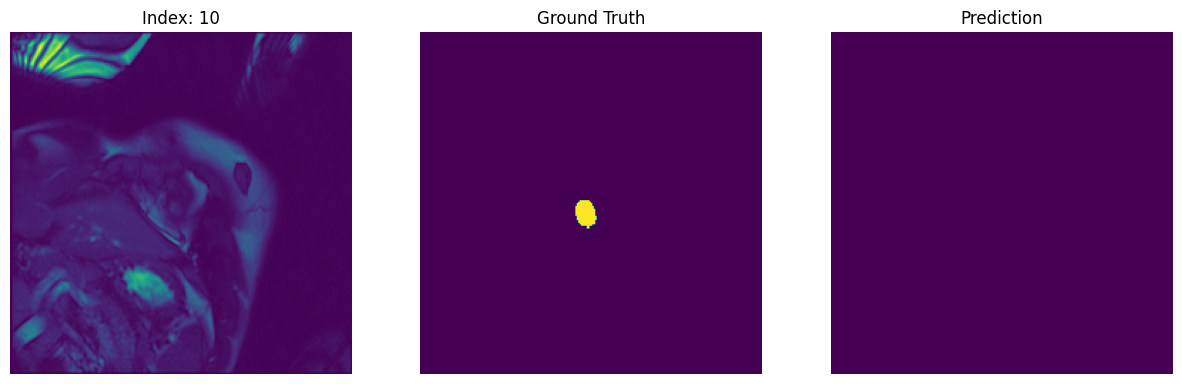

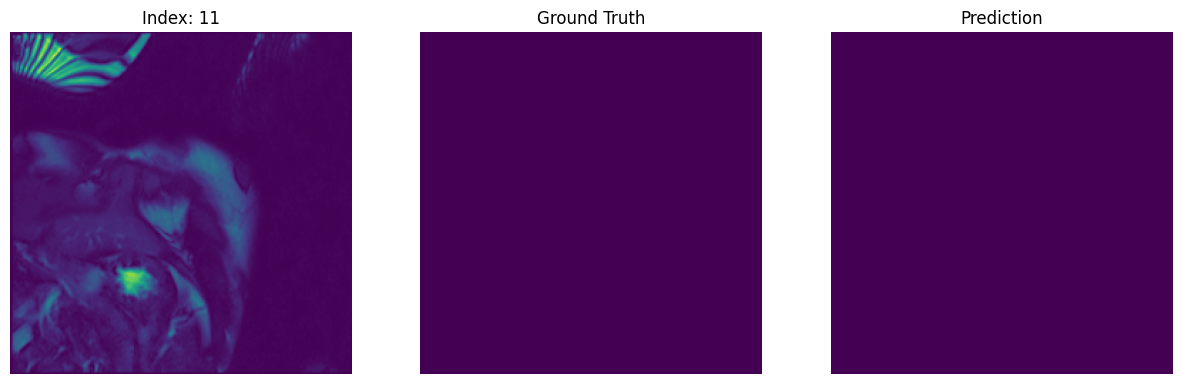

============================= 3D image no: 2


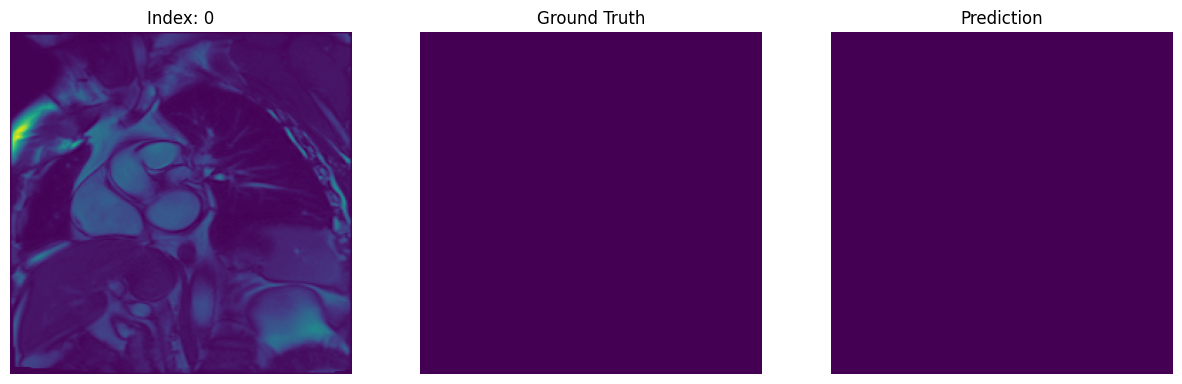

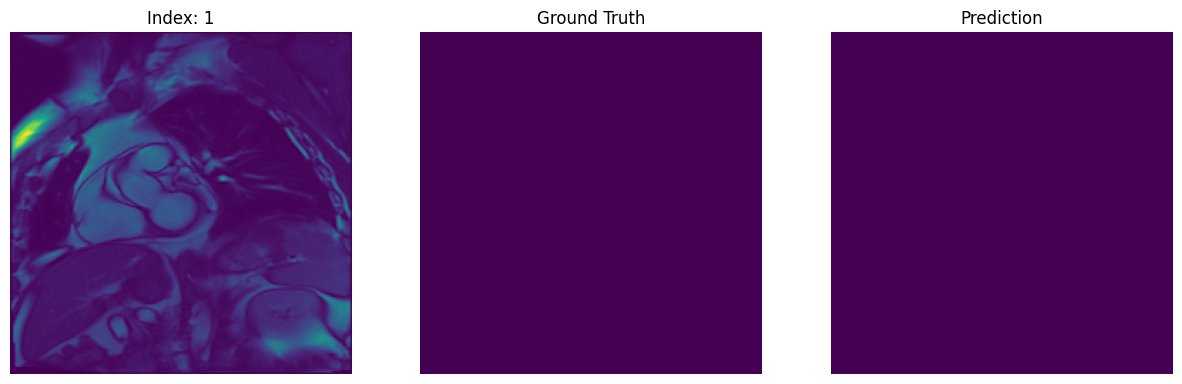

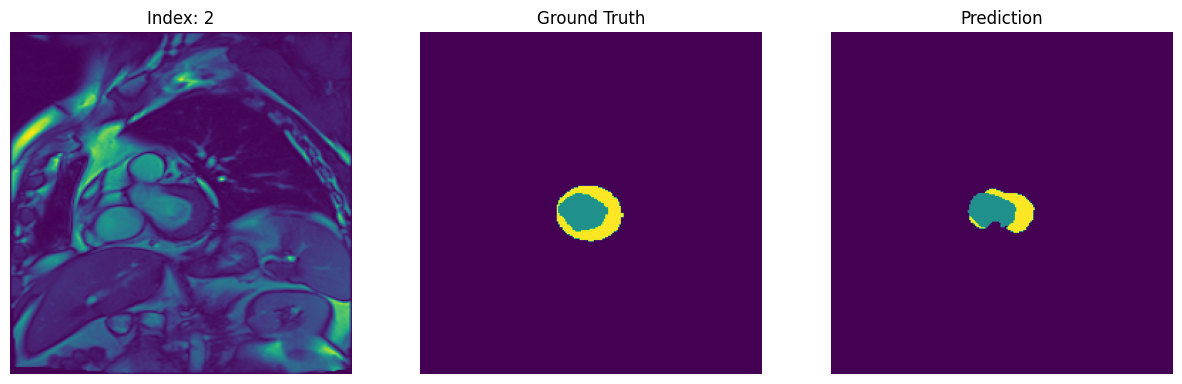

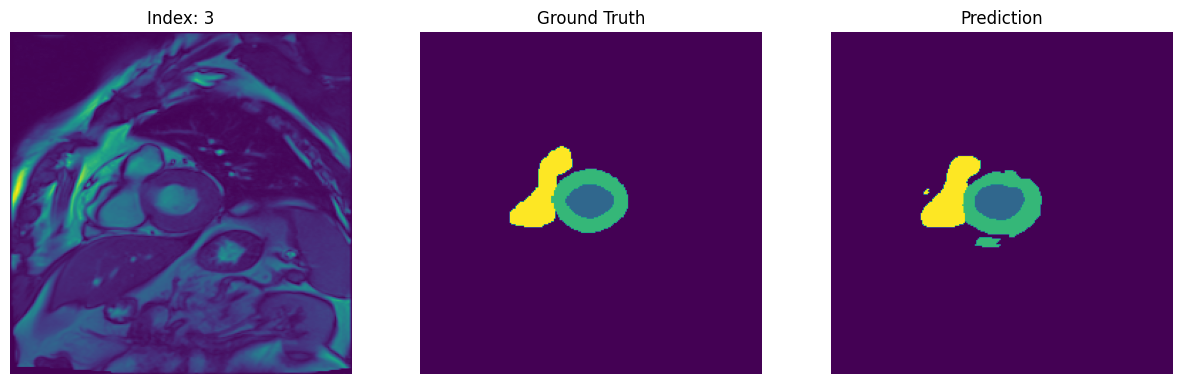

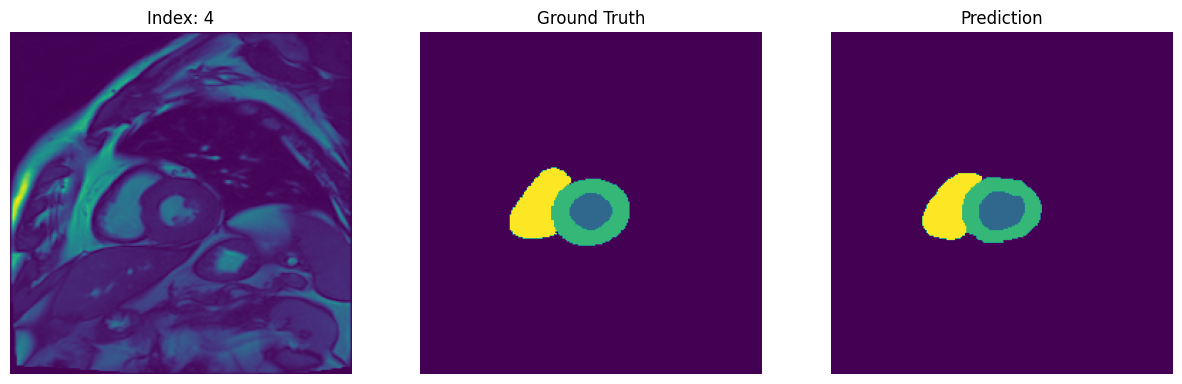

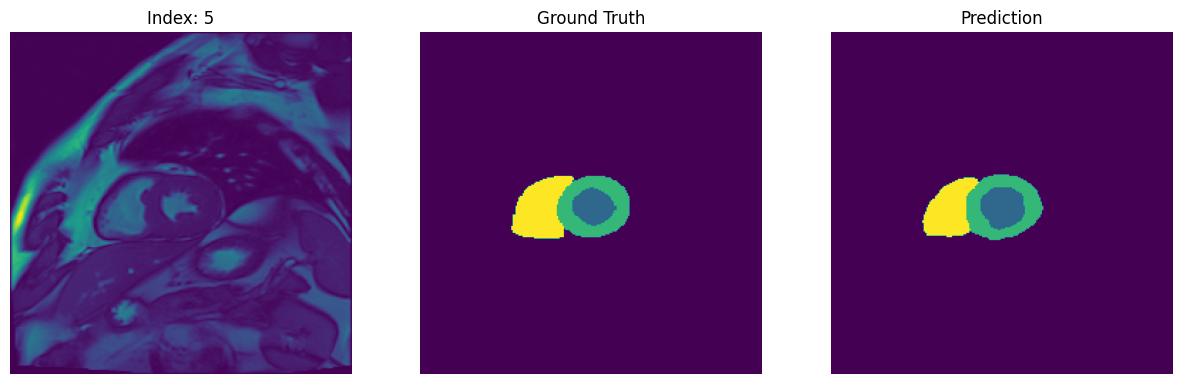

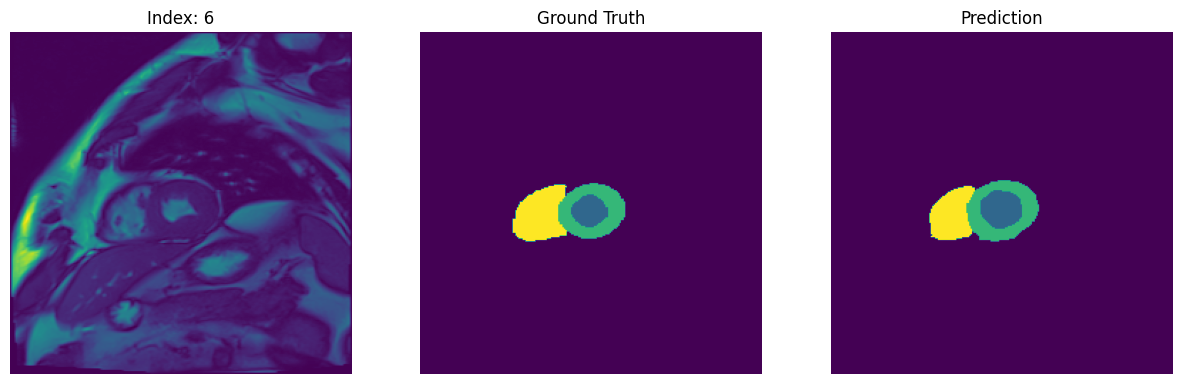

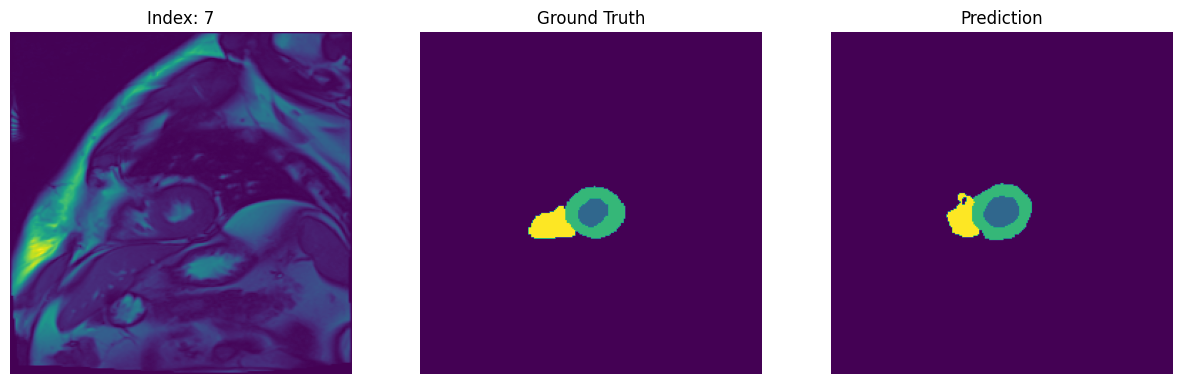

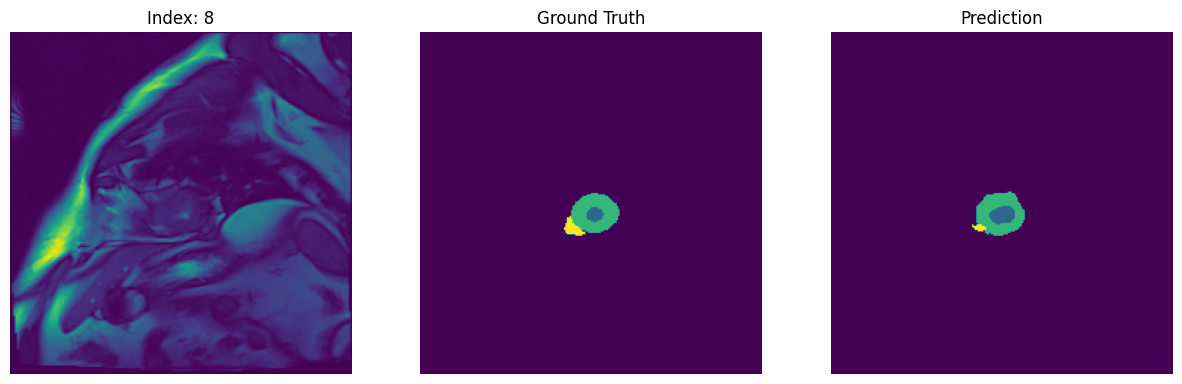

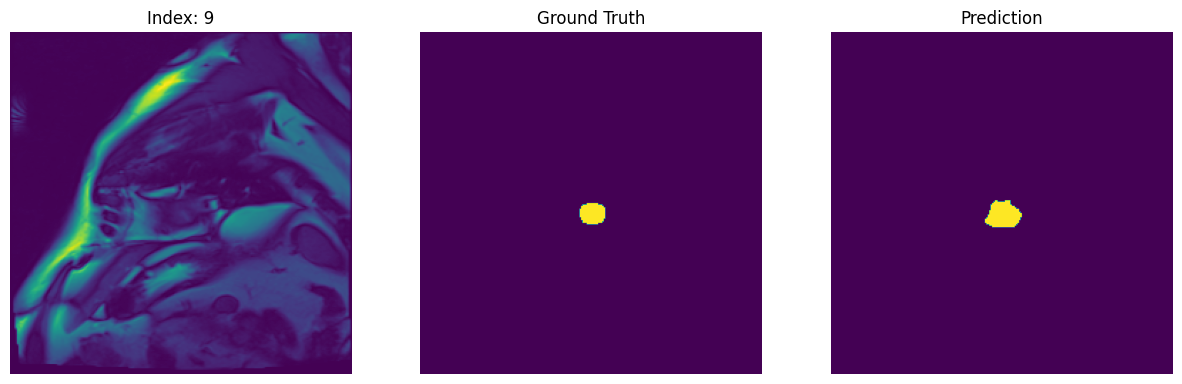

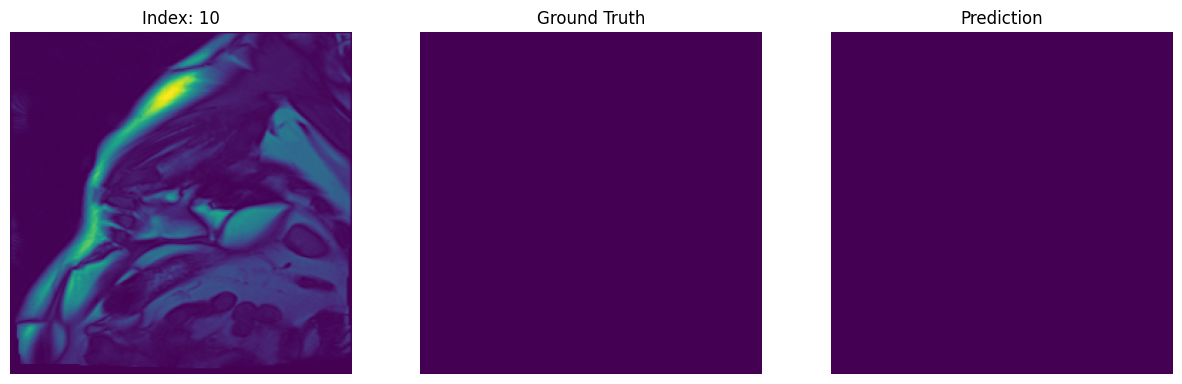

In [ ]:
inputs, classes = next(iter(test_loader))
predict_img(model,inputs.float(), classes, device)